# Refine the Baseline Regression Models

The baseline linear regression model has reasonably good RMSE and R-squared values. However, it can be improved upon by using methods like adding polynomial and interaction terms, regularisation, etc.

`tidymodels` is used to improve the performance of baseline model:

- Add polynomial terms.
- Add interactions terms.
- Add regularisation terms.
- Experiment to search for improved models.

## Load the dataset. Perform a test-train split.

Install and import necessary libraries.

In [1]:
library("tidymodels")
library("tidyverse")
library("stringr")

-- Attaching packages -------------------------------------- tidymodels 1.0.0 --

v broom        1.0.3     v recipes      1.0.5
v dials        1.1.0     v rsample      1.1.1
v dplyr        1.1.0     v tibble       3.1.8
v ggplot2      3.4.0     v tidyr        1.3.0
v infer        1.0.4     v tune         1.0.1
v modeldata    1.1.0     v workflows    1.1.3
v parsnip      1.0.4     v workflowsets 1.0.0
v purrr        1.0.1     v yardstick    1.1.0

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Use suppressPackageStartupMessages() to eliminate package startup messages

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v readr   2.1.3     v forcats 1.0.0
v stringr 1.5.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x readr::c

Download the processed and normalised dataset from the following URL:\
https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv

In [2]:
# Dataset URL
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url)
spec(bike_sharing_df)

Rows: 8465 Columns: 41
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): DATE, FUNCTIONING_DAY
dbl (39): RENTED_BIKE_COUNT, TEMPERATURE, HUMIDITY, WIND_SPEED, VISIBILITY, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

As with the baseline models:
- The `DATE` column is dropped as it acts as an index.
- The `FUNCTIONAL DAY` column is dropped, as it has only one distinct value (`YES`) remaining after removing missing values.

In [3]:
bike_sharing_df <- bike_sharing_df %>% 
                   select(-DATE, -FUNCTIONING_DAY)

Define a linear regression model specification.


In [4]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>% 
  set_mode("regression")

Split the data into training and testing datasets.


In [5]:
set.seed(1234)
data_split <- initial_split(bike_sharing_df, prop = 4/5)
train_data <- training(data_split)
test_data <- testing(data_split)

## Refinement: Add polynomial terms

Linear regression models are suitable models to capture the linear correlations. However, in real world data, many relationships may be non-linear.

The correlation between `RENTED_BIKE_COUNT` and `TEMPERATURE` does not look linear.

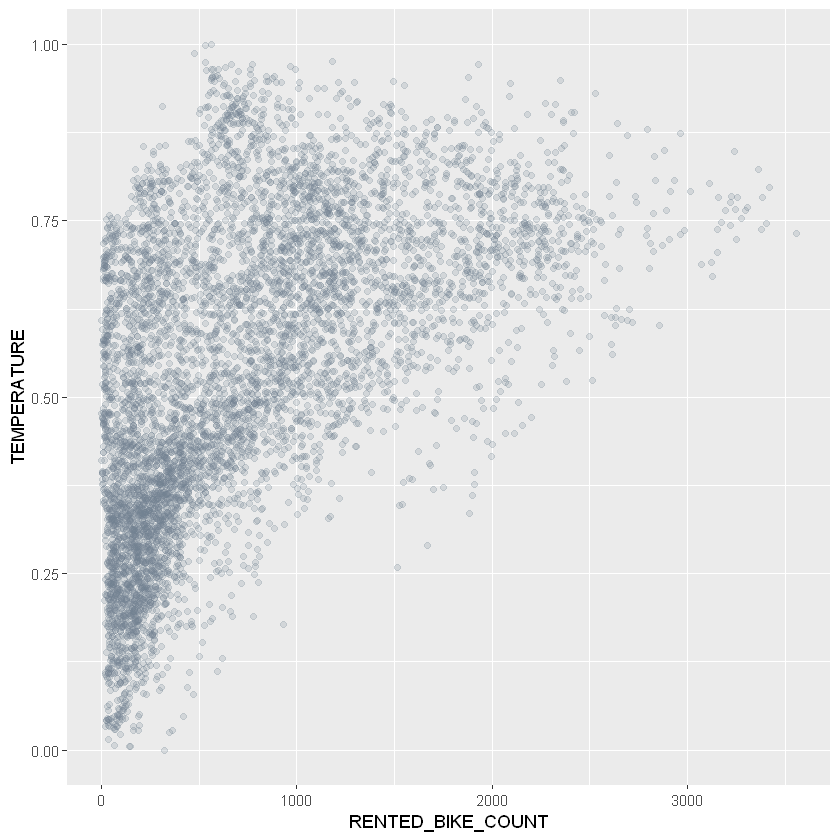

In [6]:
ggplot(data = train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point(color = "slategray", alpha = 0.2)

**Polynomial regression** can by used to handle non-linearity by adding polynomial terms. Higher order polynomials are better than the first order polynomial.  

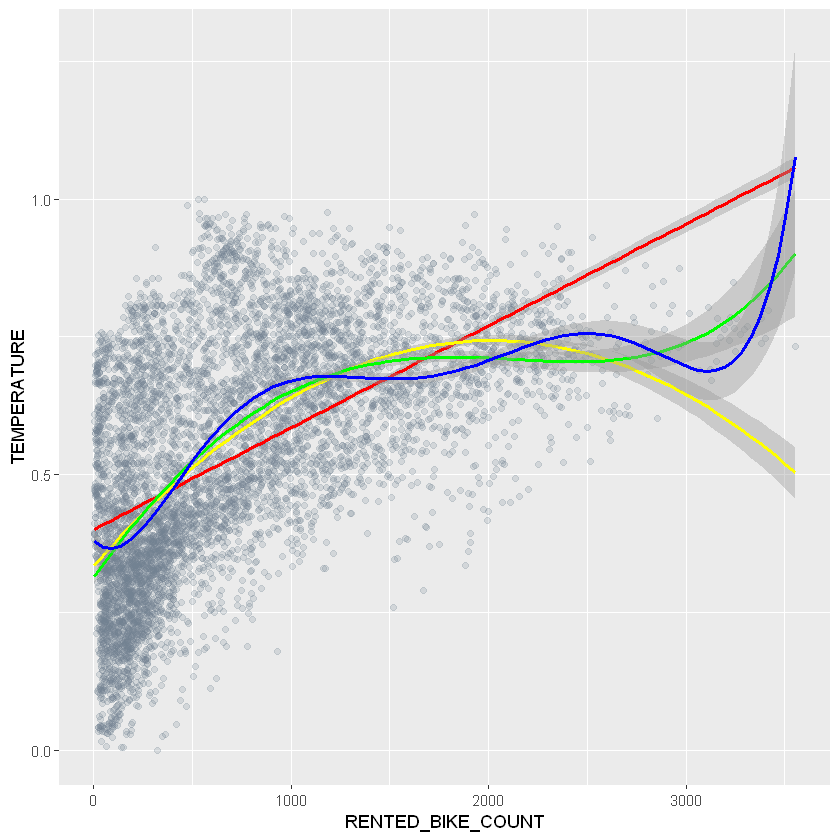

In [7]:
# Plot the higher order polynomial fits
ggplot(data=train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point(color = "slategray", alpha = 0.2)  + 
    geom_smooth(method = "lm", formula = y ~ x, color="red") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 2), color="yellow") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 4), color="green") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 6), color="blue")

Fit a linear regression model `lm_poly`, adding higher order polynomial terms on the important variables (larger coefficients) found in the baseline model.

In [8]:
# Fit a linear model with higher order polynomial on some important variables 
# The poly() function is used to build polynomial terms
lm_poly <- RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) + poly(WIND_SPEED, 4) + poly(VISIBILITY, 3) + 
                               poly(DEW_POINT_TEMPERATURE,6)+ poly(SOLAR_RADIATION, 5) + poly(RAINFALL, 6) + poly(SNOWFALL, 4) + 
                               `0` + `1` + `10` + `11` + `12` + `13` + `14` + `15` + `16` + `17` + `18` + `19` + `2` + `20` + 
                               `21` + `22` + `23` + `3` + `4` + `5` + `6` + `7` + `8`+ `9` +
                                AUTUMN + SPRING + SUMMER + WINTER + HOLIDAY + NO_HOLIDAY 

train_fit_1 <- lm_spec %>%
    fit(lm_poly,  data=train_data)

Review the model summary.

In [9]:
# Print model summary
summary(train_fit_1$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + 
    poly(HUMIDITY, 4) + poly(WIND_SPEED, 4) + poly(VISIBILITY, 
    3) + poly(DEW_POINT_TEMPERATURE, 6) + poly(SOLAR_RADIATION, 
    5) + poly(RAINFALL, 6) + poly(SNOWFALL, 4) + `0` + `1` + 
    `10` + `11` + `12` + `13` + `14` + `15` + `16` + `17` + `18` + 
    `19` + `2` + `20` + `21` + `22` + `23` + `3` + `4` + `5` + 
    `6` + `7` + `8` + `9` + AUTUMN + SPRING + SUMMER + WINTER + 
    HOLIDAY + NO_HOLIDAY, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1757.15  -181.70     5.75   169.19  1270.33 

Coefficients: (3 not defined because of singularities)
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        282.568     25.798  10.953  < 2e-16 ***
poly(TEMPERATURE, 6)1            38738.270   4225.839   9.167  < 2e-16 ***
poly(TEMPERATURE, 6)2             8906.079    715.622  12.445  < 2e-16 ***
poly(TEMPERATURE, 6)3           -10774.841

Make predictions on the test dataset using the `lm_poly` model.

In [10]:
# Use predict() to generate test results for `lm_poly`
test_results <- train_fit_1 %>%
    predict(new_data = test_data) %>% # Make the predictions and save the predicted values
    mutate(truth = test_data$RENTED_BIKE_COUNT) # Create a new column to save the true values

head(test_results)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
"prediction from a rank-deficient fit may be misleading"


.pred,truth
<dbl>,<dbl>
-233.99270,100
-107.80354,181
62.71672,360
684.66018,405
126.18219,328
305.09211,479


A minor improvement is to convert all negative prediction results to zero, because negative rented bike counts are not possible.

In [11]:
test_results[test_results<0] <- 0

head(test_results)

.pred,truth
<dbl>,<dbl>
0.00000,100
0.00000,181
62.71672,360
684.66018,405
126.18219,328
305.09211,479


Calculate R-squared and RMSE for the test results generated by the `lm_poly` model.

In [12]:
# Calculate R-squared and RMSE from the test results
rsq_1 <- rsq(test_results, truth = truth, estimate = .pred)

rmse_1 <- rmse(test_results, truth = truth, estimate = .pred)

model_1_results <- c(rsq_1, rmse_1)
model_1_results

$.metric
[1] "rsq"

$.estimator
[1] "standard"

$.estimate
[1] 0.777222

$.metric
[1] "rmse"

$.estimator
[1] "standard"

$.estimate
[1] 300.179

 `R-squared` is higher and `RMSE` lower than for the linear baseline model, demonstrating an improvement.

## Refinement: Add interaction terms

In real-world scenarios, in addition to non-linear relationships between response and predictor variables, there may be other relationships among variables, called **interaction effects**.

For example, the effect of the predictor variable `TEMPERATURE` on `RENTED_BIKE_COUNT` may also depend on other variables like `HUMIDITY`, `RAINFALL`, or both (they **interact**), and the effect of `SEASON` on `RENTED_BIKE_COUNT` may also depend on `HOLIDAY`, `HOUR`, or both.

To capture such interaction effects, **interaction terms** such as `RAINFALL*HUMIDITY` can be added to the polynomial regression model to improve its model performance.

In [13]:
# Add interaction terms to the poly regression built in previous step

# Use the `*` operator to create interaction terms such as HUMIDITY*TEMPERATURE
lm_interaction <- RENTED_BIKE_COUNT ~ `18`*TEMPERATURE*DEW_POINT_TEMPERATURE + RAINFALL*HUMIDITY*`4` + SOLAR_RADIATION*SNOWFALL +
                                      WIND_SPEED*VISIBILITY +`18`*TEMPERATURE* + poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) +
                                      poly(WIND_SPEED, 4) + poly(VISIBILITY, 3) + poly(DEW_POINT_TEMPERATURE,6)+ poly(SOLAR_RADIATION, 5) +
                                      poly(RAINFALL, 6)+ poly(SNOWFALL, 4) +
                                      `0` + `1` + `10` + `11` + `12` + `13` + `14` + `15` + `16` + `17`  + `19` + `2` + `20` +
                                      `21` + `22` + `23` + `3`  + `5` + `6` + `7` + `8`+ `9` +
                                      AUTUMN + SPRING + SUMMER + WINTER + HOLIDAY + NO_HOLIDAY 

train_fit_2 <- lm_spec %>% 
  fit(lm_interaction,  data=train_data)

train_fit_2

parsnip model object


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ `18` * TEMPERATURE * 
    DEW_POINT_TEMPERATURE + RAINFALL * HUMIDITY * `4` + SOLAR_RADIATION * 
    SNOWFALL + WIND_SPEED * VISIBILITY + `18` * TEMPERATURE * 
    +poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) + poly(WIND_SPEED, 
    4) + poly(VISIBILITY, 3) + poly(DEW_POINT_TEMPERATURE, 6) + 
    poly(SOLAR_RADIATION, 5) + poly(RAINFALL, 6) + poly(SNOWFALL, 
    4) + `0` + `1` + `10` + `11` + `12` + `13` + `14` + `15` + 
    `16` + `17` + `19` + `2` + `20` + `21` + `22` + `23` + `3` + 
    `5` + `6` + `7` + `8` + `9` + AUTUMN + SPRING + SUMMER + 
    WINTER + HOLIDAY + NO_HOLIDAY, data = data)

Coefficients:
                           (Intercept)                                    `18`  
                              2282.970                                 425.465  
                           TEMPERATURE                   DEW_POINT_TEMPERATURE  
                             -2423.675                               -8694.

Review the model summary.

In [14]:
# Print model summary
summary(train_fit_2$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ `18` * TEMPERATURE * 
    DEW_POINT_TEMPERATURE + RAINFALL * HUMIDITY * `4` + SOLAR_RADIATION * 
    SNOWFALL + WIND_SPEED * VISIBILITY + `18` * TEMPERATURE * 
    +poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) + poly(WIND_SPEED, 
    4) + poly(VISIBILITY, 3) + poly(DEW_POINT_TEMPERATURE, 6) + 
    poly(SOLAR_RADIATION, 5) + poly(RAINFALL, 6) + poly(SNOWFALL, 
    4) + `0` + `1` + `10` + `11` + `12` + `13` + `14` + `15` + 
    `16` + `17` + `19` + `2` + `20` + `21` + `22` + `23` + `3` + 
    `5` + `6` + `7` + `8` + `9` + AUTUMN + SPRING + SUMMER + 
    WINTER + HOLIDAY + NO_HOLIDAY, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1967.17  -176.78     5.39   166.77  1265.46 

Coefficients: (22 not defined because of singularities)
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                              2282.970    774.652   2.947 0.003219
`18`                                  

In [15]:
test_results_2 <- train_fit_2 %>%
    predict(new_data = test_data) %>% # Make the predictions and save the predicted values
    mutate(truth = test_data$RENTED_BIKE_COUNT) # Create a new column to save the true values

head(test_results_2)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
"prediction from a rank-deficient fit may be misleading"


.pred,truth
<dbl>,<dbl>
-241.84214,100
-111.95731,181
70.52095,360
686.25512,405
124.27863,328
311.03548,479


In [16]:
test_results_2[test_results_2<0] <- 0
head(test_results_2)

.pred,truth
<dbl>,<dbl>
0.00000,100
0.00000,181
70.52095,360
686.25512,405
124.27863,328
311.03548,479


Calculate R-squared and RMSE for the test results generated by the `lm_interaction` model.

In [17]:
# Calculate R-squared and RMSE for the new model to see if performance has improved
rsq_2 <- rsq(test_results_2, truth = truth, estimate = .pred)

rmse_2 <- rmse(test_results_2, truth = truth, estimate = .pred)

model_2_results <- c(rsq_2, rmse_2)
model_2_results

$.metric
[1] "rsq"

$.estimator
[1] "standard"

$.estimate
[1] 0.7828358

$.metric
[1] "rmse"

$.estimator
[1] "standard"

$.estimate
[1] 296.2711

## Refinement: Add regularisation

Although adding polynominal and interaction terms to the model improves performance, it also makes the model more complicated, more difficult to explain, and more likely to suffer from overfitting

A solution is to add **regularisation terms** to the model.

Instead of the basic `lm` engine, a more advanced and generalised `glmnet` engine is used. It provides a generalised linear model with Lasso, Ridge, and Elastic Net regularisations.

Generally, using `glmnet` can enhance models in the following ways:
- Address overfitting by shrinking the coefficients.
- Address predictor variable collinearity by selecting only one variable from each group of collinear variables (by shrinking their coefficients to zero).
- Models are made more interpretable due to simplification (fewer variables in the outcome models).

Define a linear regression model specification `glmnet_spec` using `glmnet` engine.

In [18]:
# Use linear_reg() with two parameters: penalty and mixture
## penalty: controls the intensity of model regularisation
## mixture: controls the tradeoff between L1 and L2 regularisations

# Different parameter combinations can be tried manually or grid search can be used to find optimal combinations.

Fit a glmnet model using the `fit()` function. For the formula, keep the polynominal and interaction terms already used.

In [19]:
install.packages('glmnet')
library('glmnet')

package 'glmnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\djtal\AppData\Local\Temp\RtmpkTcNhs\downloaded_packages


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-6



In [20]:
# Fit a glmnet model using the fit() function
glmnet_spec <- linear_reg(penalty = 0.2, mixture = 0.5) %>%
  set_engine("glmnet") %>%
  set_mode("regression")

In [21]:
glmnet_fit <- glmnet_spec %>%
    fit(RENTED_BIKE_COUNT ~ `18`*TEMPERATURE*DEW_POINT_TEMPERATURE + RAINFALL*HUMIDITY*`4` + SOLAR_RADIATION*SNOWFALL +
                            poly(DEW_POINT_TEMPERATURE,6) + poly(SOLAR_RADIATION, 5) + poly(RAINFALL, 6) + poly(SNOWFALL, 4) +
                            `0` + `1` + `10` + `11` + `12` + `13` + `14` + `15` + `16` + `17`  + `19` + `2` + `20` +
                            `21` + `22` + `23` + `3`  + `5` + `6` + `7` + `8`+ `9` + AUTUMN+ SPRING + SUMMER + WINTER + HOLIDAY + NO_HOLIDAY,
        data = train_data)

In [22]:
test_results_glmnet <- glmnet_fit %>%
    predict(new_data = test_data) %>% # Make the predictions and save the predicted values
    mutate(truth = test_data$RENTED_BIKE_COUNT) # Create a new column to save the true values

head(test_results_glmnet)     

.pred,truth
<dbl>,<dbl>
-222.49628,100
-79.87442,181
267.31530,360
597.35678,405
64.69997,328
385.33371,479


Calculate R-squared and RMSE for the test results generated by the `glmnet` model.

In [23]:
# Report rsq and rmse of the `lm_glmnet` model
rsq_3 <- rsq(test_results_glmnet, truth = truth, estimate = .pred)

rmse_3 <-rmse(test_results_glmnet, truth = truth, estimate = .pred)

model_3_results <- c(rsq_3, rmse_3)
model_3_results

$.metric
[1] "rsq"

$.estimator
[1] "standard"

$.estimate
[1] 0.7177087

$.metric
[1] "rmse"

$.estimator
[1] "standard"

$.estimate
[1] 336.281

## Experiment to search for improved models.

Experiment by building and testing at least five different models. For each experiment, include polynomial terms, interaction terms, and one of the three regularisations introduced.

In [24]:
model_prediction <- function(model_fit, test_data)
{
    test_results <- model_fit %>%
        predict(new_data = test_data) %>%
        mutate(truth = test_data$RENTED_BIKE_COUNT)
    test_results[test_results<0] <- 0
    return(test_results)
}

In [25]:
model_evaluation <- function(test_results)
{
    rsq_model <- rsq(test_results, truth = truth, estimate = .pred)
    rmse_model <- rmse(test_results, truth = truth, estimate = .pred)
    results <- c(rsq_model, rmse_model)
    return(results)
}

In [26]:
# Build at least five different models using polynomial terms, interaction terms, and regularizations.
# Save their rmse and rsq values.
# Since 3 models have already been built, 2 more are built below.

### Model 4

In [27]:
# model_4
lm_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

model_4_fit <- lm_spec %>%
    fit(RENTED_BIKE_COUNT ~ `18`*TEMPERATURE*DEW_POINT_TEMPERATURE + RAINFALL*HUMIDITY*`4` +SOLAR_RADIATION*SNOWFALL +
                            WIND_SPEED*VISIBILITY +`18`*TEMPERATURE+RAINFALL*HUMIDITY*`18` + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) +
                            poly(WIND_SPEED, 2) + poly(VISIBILITY, 3) + poly(DEW_POINT_TEMPERATURE,6) + poly(SOLAR_RADIATION, 5) +
                            poly(RAINFALL, 6) + poly(SNOWFALL, 2) +
                            `18`+`4` + `0` + `1` + `10` + `11` + `12` + `13` + `14` + `15` + `16` + `17`  + `19` + `2` + `20` +
                            `21` + `22` + `23` + `3`  + `5` + `6` + `7` + `8`+ `9` +
                            AUTUMN + SPRING + SUMMER + WINTER + HOLIDAY + NO_HOLIDAY + AUTUMN*SPRING*SUMMER*WINTER*HOLIDAY*`18`*`4`*`19`,
        data = train_data)

pred_model_4 <- model_prediction(model_4_fit, test_data)
model_4_results <- model_evaluation(pred_model_4)
model_4_results

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
"prediction from a rank-deficient fit may be misleading"


$.metric
[1] "rsq"

$.estimator
[1] "standard"

$.estimate
[1] 0.7971291

$.metric
[1] "rmse"

$.estimator
[1] "standard"

$.estimate
[1] 285.7007

### Model 5

In [28]:
#model_5
# Fit a glmnet model using the fit() function
glmnet_spec <- linear_reg(penalty = 0.2, mixture = 0.5) %>%
    set_engine("glmnet") %>%
    set_mode("regression")

#model_5
glmnet_fit <- glmnet_spec %>%
    fit(RENTED_BIKE_COUNT ~ `18`*TEMPERATURE*DEW_POINT_TEMPERATURE + RAINFALL*HUMIDITY*`4` + SOLAR_RADIATION*SNOWFALL +
                            WIND_SPEED*VISIBILITY +`18`*TEMPERATURE+RAINFALL*HUMIDITY*`18` + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) +
                            poly(WIND_SPEED, 2) + poly(VISIBILITY, 3) + poly(DEW_POINT_TEMPERATURE,6) + poly(SOLAR_RADIATION, 5) +
                            poly(RAINFALL, 6) + poly(SNOWFALL, 2) +
                            `18`+`4`+ `0` + `1` + `10` + `11` + `12` + `13` + `14` + `15` + `16` + `17`  + `19` +
                            `2` + `20` + `21` + `22` + `23` + `3`  + `5` + `6` + `7` + `8`+ `9` +
                            AUTUMN + SPRING + SUMMER + WINTER + HOLIDAY + NO_HOLIDAY + AUTUMN*SPRING*SUMMER*WINTER*HOLIDAY*`18`*`4`*`19`,
        data = train_data)

pred_model_5 <- model_prediction(glmnet_fit, test_data)
model_5_results <- model_evaluation(pred_model_5)
model_5_results

$.metric
[1] "rsq"

$.estimator
[1] "standard"

$.estimate
[1] 0.7963428

$.metric
[1] "rmse"

$.estimator
[1] "standard"

$.estimate
[1] 286.3185

### Generate a dataframe of model results

In [29]:
# Report the best performing model in terms of rmse and rsq
rsq_rmse_data <- data.frame(model_1_results)
rsq_rmse_data <- rbind(rsq_rmse_data, model_2_results, model_3_results, model_4_results, model_5_results)

rsq_rmse_data['model'] <- c("m1_poly", "m2_interaction", "m3_glmnet", "m4_higher_poly", "m5_higher_glmnet")
colnames(rsq_rmse_data)[6] <- "RMSE"
colnames(rsq_rmse_data)[3] <- "Rsquared"

rsq_rmse_data$model_factor <- as.factor(rsq_rmse_data$model)
rsq_rmse_data

.metric,.estimator,Rsquared,.metric.1,.estimator.1,RMSE,model,model_factor
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<fct>
rsq,standard,0.7772220,rmse,standard,300.1790,m1_poly,m1_poly
rsq,standard,0.7828358,rmse,standard,296.2711,m2_interaction,m2_interaction
rsq,standard,0.7177087,rmse,standard,336.2810,m3_glmnet,m3_glmnet
rsq,standard,0.7971291,rmse,standard,285.7007,m4_higher_poly,m4_higher_poly
rsq,standard,0.7963428,rmse,standard,286.3185,m5_higher_glmnet,m5_higher_glmnet


Performance requirements for the best model:
- The RMSE should be less than 330 (roughly 10% of the max value in test dataset)
- R-squared should be greater than 0.72

### Visualize the saved RMSE and R-squared values using a grouped barchart

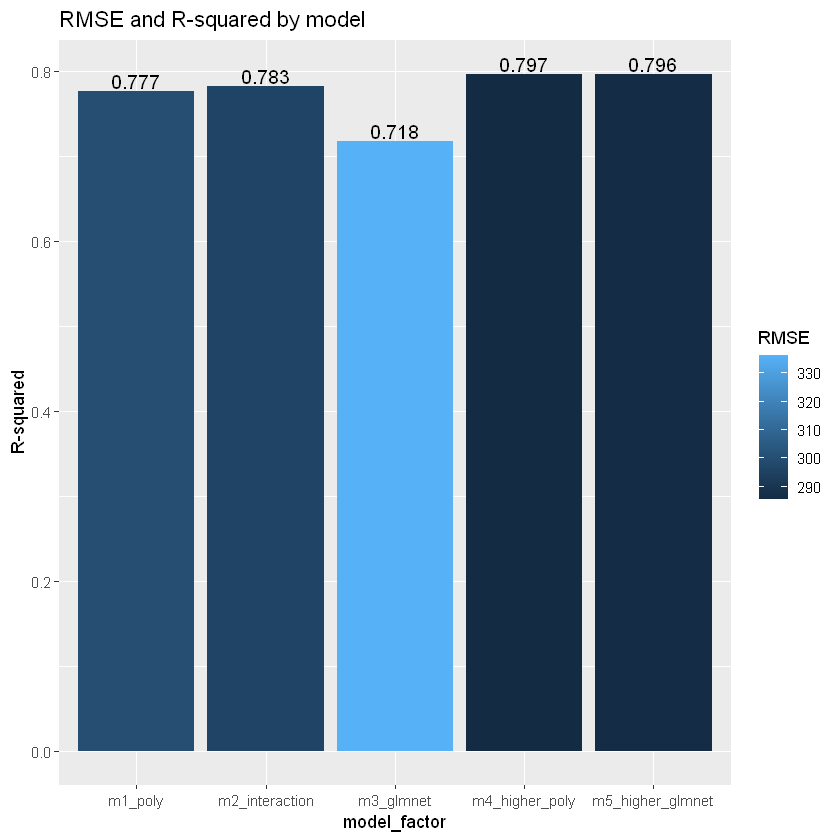

In [30]:
ggplot(rsq_rmse_data, aes(x = model_factor, y = Rsquared, fill = RMSE)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label = format(round(Rsquared, 3), nsmall = 2)), vjust = -0.2, size = 4) +
    labs(y = "R-squared", title = "RMSE and R-squared by model") 

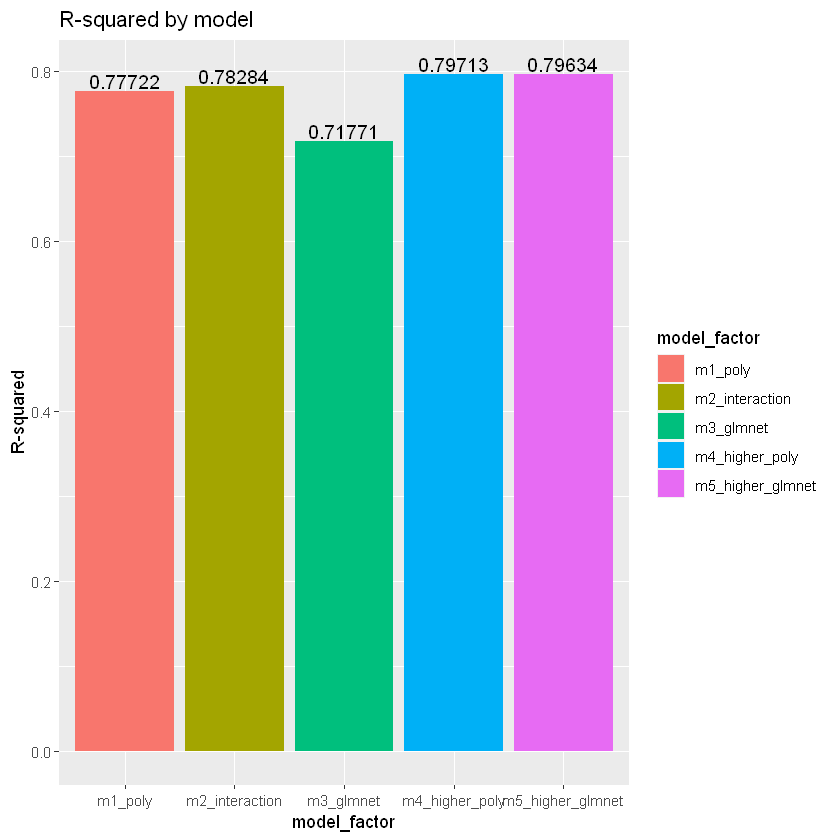

In [31]:
ggplot(rsq_rmse_data, aes(x = model_factor, y = Rsquared, fill = model_factor)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label = format(round(Rsquared, 5), nsmall = 2)), vjust = -0.2, size = 4) +
    labs(y = "R-squared", title = "R-squared by model") 

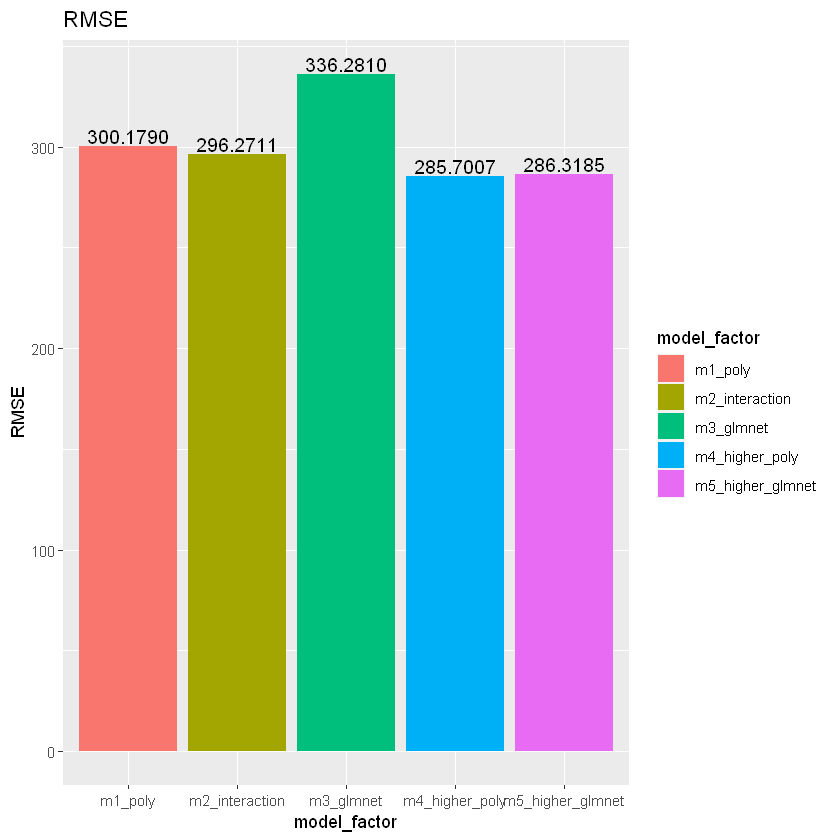

In [32]:
ggplot(rsq_rmse_data, aes(x = model_factor, y = RMSE, fill = model_factor)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label = format(round(RMSE, 5), nsmall = 2)), vjust = -0.2, size = 4) +
    labs(y = "RMSE", title = "RMSE") 

 The **Polynomial Regression model with added terms** has the highest R-squared (0.79713) and the lowest RMSE (285.7007) and is therefore the best performing model.

### Q-Q plot of the best performing model

Create a **Q-Q plot** by plotting the distribution difference between the predictions generated by the best model and the true values on the test dataset.

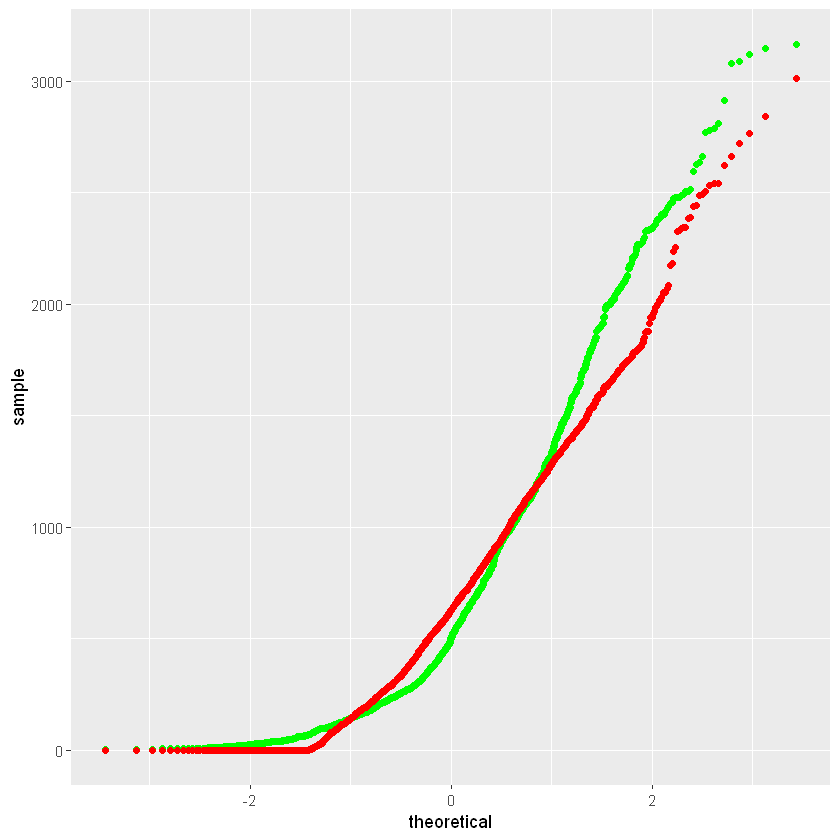

In [34]:
ggplot(pred_model_4) +
    stat_qq(aes(sample=truth), color='green') +
    stat_qq(aes(sample=.pred), color='red')

## Additional possible model improvment methods

The following methods can be used to further explore model performance improvement:
 - **Remove potential redundant variables:** Highly correlated variables may possibly be redundant.
 - **Remove some outliers:** Linear regression models are very sensitive to outliers.
 - **Apply logarithm transformation:** For variable distributions that are not normal distributions, e.g. **log-normal distribution**, log transformation can be applied to the variable to make it look more like a normal distribution. Log transformation helps capture the non-linear relationship.